# Breast Cancer Wisconson Dataset

## Data Challenge
You belong to the data team at a local research hospital. You've been tasked with developing a means to help doctors diagnose breast cancer. You've been given data about east cells; where biopsied brit is benign (not harmful) or malignant (cancerous).
1.	What features of a cell are the largest drivers of malignancy?
2.	How would a physician use your product?
3.	There is a non-zero cost in time and money to collect each feature about a given cell. How would you go about determining the most cost-effective method of detecting malignancy?

## Data & Features
The dataset contains the following features for each cell:
Sample code number: id number

* Clump Thickness: 1 - 10
* Uniformity of Cell Size: 1 - 10
* Uniformity of Cell Shape: 1 - 10
* Marginal Adhesion: 1 - 10
* Single Epithelial Cell Size: 1 - 10
* Bare Nuclei: 1 - 10
* Bland Chromatin: 1 - 10
* Normal Nucleoli: 1 - 10
* Mitoses: 1 - 10
* Class: (2 for benign, 4 for malignant)

## Table of Contents
- Initial Data Analysis
- Data Wrangling
- Exploratory Data Analysis
- Machine Learning

# Imports & load data

## Import packages

In [1]:
import numpy as np
import pandas as pd
pd.set_option('precision', 3)

from scipy import stats
from scipy.stats import norm, shapiro, skew, kurtosis
import statsmodels.api as sm

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.decomposition import PCA
from pca import pca
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist

from sklearn.metrics import classification_report, confusion_matrix
from sklearn import metrics
from sklearn.metrics import silhouette_score

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_context('poster')
sns.set_style('whitegrid') 
plt.rcParams['figure.figsize'] = 18, 12

import warnings
warnings.filterwarnings('ignore')

## Import functions

In [2]:
def percent_missing(df):
    """
    Given a dataframe it calculates the percentage of missing records per column
    Params:
        - df
    Returns:
        - Dictionary of column name and percentage of missing records
    """
    col=list(df.columns)
    perc=[round(df[c].isna().mean()*100,2) for c in col]
    miss_dict=dict(zip(col,perc))
    sns.heatmap(df.isnull(),yticklabels=False,cbar=False,cmap='viridis')
    return miss_dict

def normality_test(df,col_list):
    """
    Given a dataframe determines whether each numerical column is Gaussian 
    Ho = Assumes distribution is not Gaussian
    Ha = Assumes distribution is Gaussian
    Params:
        - df
    Returns:
        - W Statistic
        - p-value
        - List of columns that do not have gaussian distribution
    """
    warnings.filterwarnings("ignore", category=UserWarning)

    non_gauss=[]
    w_stat=[]
    # Determine if each sample of numerical feature is gaussian
    alpha = 0.05
    
    i = 1
    for col in col_list:
        stat,p=shapiro(df[col])
        plt.figure(figsize = (12,4))
        sns.distplot(df[col])
        plt.show();
        print(skew(df[col]),kurtosis(df[col]))
        i += 1
      
        if p <= alpha: # Reject Ho -- Distribution is not normal
            non_gauss.append(col)
            w_stat.append(stat)
    # Dictionary of numerical features not gaussian and W-Statistic        
    norm_dict=dict(zip(non_gauss,w_stat))
    return norm_dict


def plot_hist(df_list, col, labels = [], log = False, normalized = True):
    """
    Overlay histogram plot based on class label.
    
    Input: 
        df_list: Dataframe of each class
        col: Desired column names (list of string values)
        labels: Class label
    Optional:
        log: log of values (default False)
        normalized: plot histogram using normalized values (default True)
    """
    plt.figure(figsize = (18,4))
    for i, df in enumerate(df_list):
        if log:
            if normalized:
                plt.hist(np.log10(df[col].values + 0.01), bins=10, alpha=0.5, label=labels[i], density = True)
                plt.ylabel('Normalized Count')
            else: 
                plt.hist(np.log10(df[col].values + 0.01), bins=10, alpha=0.5, label=labels[i], density = False)
                plt.xlabel('Log feature values')
                plt.ylabel('Count')
            plt.title('Log ' + col)

        else:
            if normalized:
                plt.hist(df[col], bins=20, alpha=0.5, label=labels[i], density = True)
                plt.xlabel('Feature values')
                plt.ylabel('Normalized Count')
            else: 
                plt.hist(df[col], bins=20, alpha=0.5, label=labels[i], density = False)
                plt.xlabel('Feature values')
                plt.ylabel('Count Count')
            plt.title(col)
    plt.legend(fontsize=14, frameon=False, loc = 'upper right')
    plt.tight_layout()
    plt.show()
    
def logit_pvalue(model, X):
    """ Calculate z-scores for scikit-learn LogisticRegression.
    parameters:
        model: fitted sklearn.linear_model.LogisticRegression with intercept and large C
        X:     matrix on which the model was fit
    This function uses asymtptics for maximum likelihood estimates.
    """
    
    
    p = model.predict_proba(X)
    n = len(p)
    m = len(model.coef_[0]) + 1
    coefs = np.concatenate([model.intercept_, model.coef_[0]])
    X_full = np.matrix(np.insert(np.array(X), 0, 1, axis = 1))
    ans = np.zeros((m, m))
    for i in range(n):
        ans = ans + np.dot(np.transpose(X_full[i, :]), X_full[i, :]) * p[i,1] * p[i, 0]
    vcov = np.linalg.inv(np.matrix(ans))
    se = np.sqrt(np.diag(vcov))
    t =  coefs/se  
    p = (1 - norm.cdf(abs(t))) * 2
    return p


def scaleData(data, method='std'):
    """
    Scale feature values using standardization technique.
    
    Input = Dataframe
    Output = Dataframe
    """
    scalerMeth = {"std":StandardScaler()}
    scaler = scalerMeth[method]
    scaler.fit(data)
    scaled_data = pd.DataFrame(scaler.transform(data), columns=data.columns)
    return scaled_data

    # Don't need this for this challenge but may come in handy for future challenges
# def strip_obj(col):
#     """
#     Remove whitespace from strings in object-type columns
#     col: obj -> str
#     """
#     if col.dtypes == object:
#         return (col.astype(str)
#                    .str.strip()
#                    .replace({'nan': np.nan}))
#     return col

# bc = bc.apply(strip_obj, axis=0)

# Another way to remove white space from string type columns. Doesn't work well with object-type columns 
# since there can be multiple formats in the same column (int, string ,etc)
# bc = bc.apply(lambda x: x.str.strip() if x.dtype == "string" else x)


### Load data.

In [3]:
bc = pd.read_csv('breast-cancer-wisconsin.txt')
bc.drop('Index', axis=1, inplace = True)

# Initial Data Analysis

<b>Data types.</b> Expected all columns to be integer values. Some columns pertaining to app usage from day 11 to day 14 contain missing values.

In [4]:
bc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15855 entries, 0 to 15854
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   ID                           15855 non-null  int64 
 1   Clump Thickness              15855 non-null  int64 
 2   Uniformity of Cell Size      15827 non-null  object
 3   Uniformity of Cell Shape     15827 non-null  object
 4   Marginal Adhesion            15827 non-null  object
 5   Single Epithelial Cell Size  15827 non-null  object
 6   Bare Nuclei                  15827 non-null  object
 7   Bland Chromatin              15827 non-null  object
 8   Normal Nucleoli              15827 non-null  object
 9   Mitoses                      15827 non-null  object
 10  Class                        15827 non-null  object
dtypes: int64(2), object(9)
memory usage: 1.3+ MB


<b>Preview data.</b>

In [5]:
bc.head(20)

,ID,Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses,Class
0,1241035,7,8,3,7,4,5,7,8,2,4
1,1107684,6,10,5,5,4,10,6,10,1,4
2,691628,8,6,4,10,10,1,3,5,1,4
3,1226612,7,5,6,3,3,8,7,4,1,4
4,1142706,5,10,10,10,6,10,6,5,2,4
5,601265,10,4,4,6,2,10,2,3,1,4
6,378275,10,9,7,3,4,2,7,7,1,4
7,1142706,5,10,10,10,6,10,6,5,2,4
8,601265,10,4,4,6,2,10,2,3,1,4
9,1226612,7,5,6,3,3,8,7,4,1,4


<b>Remove non-integer values.</b> Several features contain non-integer values - specifically, string characters such as '?' or "No idea". Since the features should only contain integer values ranging from 1 to 10, non-integer values are replaced with missing values.

In [6]:
# Convert columns to numeric type to replace non-integers with nan
bc = bc.apply(pd.to_numeric, errors='coerce')

# Alternative approach to remove specific values
# missing_vals = ["No idea", np.nan, "#", "?"]
# bc = bc.replace(missing_vals, np.nan)

## Missing Values

<b>Check missing values.</b> Some users are missing information from at least one feature.

{'ID': 0.0,
 'Clump Thickness': 0.0,
 'Uniformity of Cell Size': 0.5,
 'Uniformity of Cell Shape': 0.5,
 'Marginal Adhesion': 0.5,
 'Single Epithelial Cell Size': 0.5,
 'Bare Nuclei': 0.6,
 'Bland Chromatin': 0.5,
 'Normal Nucleoli': 0.5,
 'Mitoses': 0.5,
 'Class': 0.5}

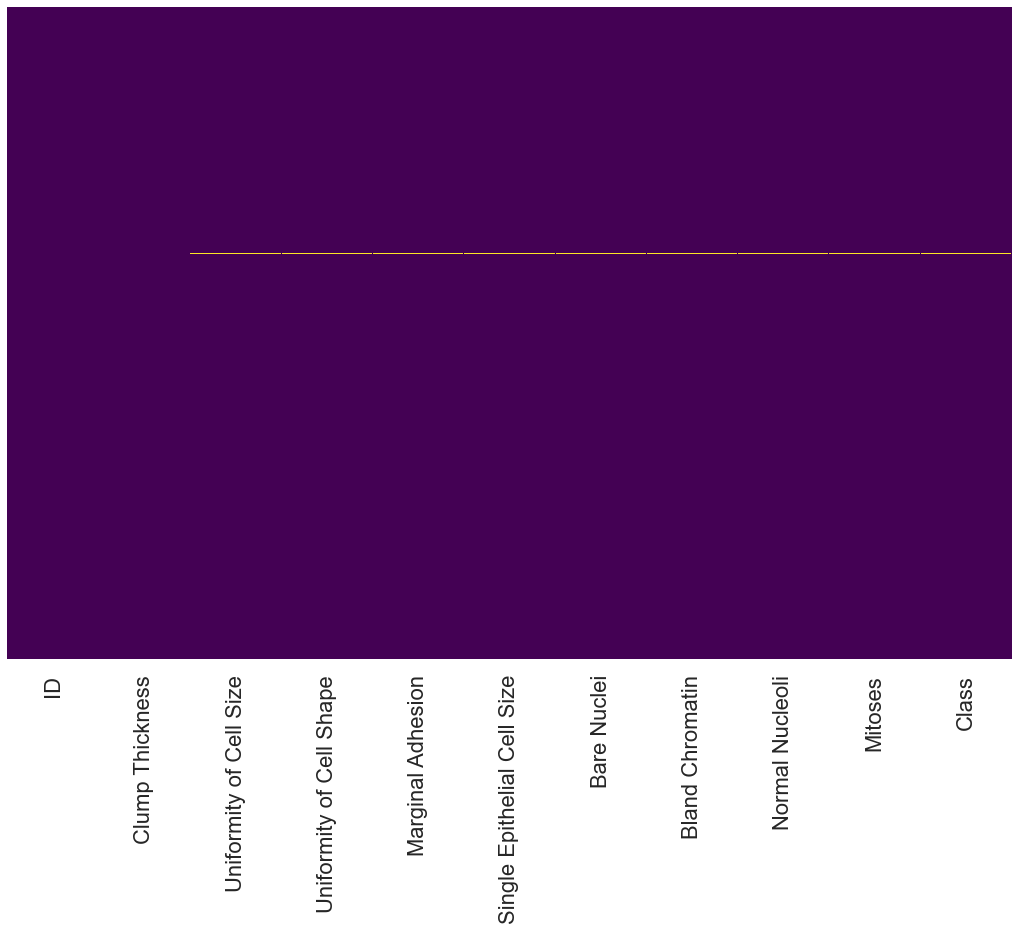

In [7]:
# Relative ratio of missing values
percent_missing(bc)

In [8]:
# Find columns with missing values
bc[bc.isnull().any(axis=1)].head()

,ID,Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses,Class
30,1226612,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
70,1076352,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
157,1057067,1,1.0,1.0,1.0,1.0,NaN,1.0,1.0,1.0,2.0
355,1111249,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
396,1111249,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<b>Remove rows missing class information.</b>

In [9]:
# Remove rows containing missing values in the Class column
bc.dropna(subset = ["Class"], inplace=True)

# Find columns with missing values
bc[bc.isnull().any(axis=1)].head()

,ID,Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses,Class
157,1057067,1,1.0,1.0,1.0,1.0,NaN,1.0,1.0,1.0,2.0
1144,1238464,1,1.0,1.0,1.0,1.0,NaN,2.0,1.0,1.0,2.0
1799,169356,3,1.0,1.0,1.0,2.0,NaN,3.0,1.0,1.0,2.0
2398,563649,8,8.0,8.0,1.0,2.0,NaN,6.0,10.0,1.0,4.0
3727,61634,5,4.0,3.0,1.0,2.0,NaN,2.0,3.0,1.0,2.0


<b>Impute missing feature values.</b> Missing values from the Bare Nuclei column were imputed using the mean Bare Nuclei score based on the value of Clump Thickness, which was the only feature that did not have any missing values in the original dataset.

In [10]:
# Impute missing values for all columns
for i in bc.columns:
    bc[i]=bc[i].fillna(bc.groupby('Clump Thickness')[i].transform('mean'))

## Duplicate entries

<b>Check for duplicate rows.</b> There are several duplicate rows in the dataset.

In [11]:
# Check if all user ID's are unique values
print(round(bc['ID'].nunique()/len(bc)*100, 2), 'percent of user ID contain unique values')

4.22 percent of user ID contain unique values


<b>Remove duplicate rows.</b>

In [12]:
# Remove duplicated rows (identical ID & all feature values)
bc = bc[~bc.duplicated()]

# Alternative Method
# bc.drop_duplicates(inplace = True)

<b>Check for duplicate ID.</b> There are several duplicate IDs in which one feature has different values. To address this, the values for duplicate ID's will be averaged.

In [13]:
# Check if all user ID's are unique values
print(round(bc['ID'].nunique()/len(bc)*100, 2), 'percent of user ID contain unique values')

# Show rows that have duplicated id
(bc[bc['ID'].duplicated(keep=False)]).sort_values(by='ID')

# Average feature values per ID
bc = bc.groupby("ID").mean() # Note: This method sets "ID" as the index.

93.66 percent of user ID contain unique values


<b>Check for duplicate indices.</b>

In [14]:
# Find duplicate index
bc[bc.index.duplicated()]

# Remove all except first duplicate
# Method 1
# bc.groupby(bc.index).first()

# Method 2 (faster)
# bc[~bc.index.duplicated(keep = 'first')]

,Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses,Class
ID,,,,,,,,,,


## Unexpected feature values

<b>Find rows with at least one feature that has a value greater than 10.</b> Some rows have all feature values multiplied by 10. These rows will be divided by ten so that the feature values fall within the expected range of 1-10.

In [15]:
# Find rows with at least one feature value > 10
bc[bc.T[(bc.T > 10)].any()]

# For rows with at least one value > 10, divide whole row by 10.
divide_by_10_rows = bc[bc.T[(bc.T > 10)].any()]/10

# Rows with feature values <= 10
clean_rows = bc[~bc.T[(bc.T > 10)].any()]

# Combine clean data
bc = pd.concat([divide_by_10_rows, clean_rows])

# Divide feature value by 10 if value > 10
# Note: This doesn't work because some rows may have value "1" that was multiplied to "10"
# bc = bc.apply(lambda x: np.where(x > 10 ,x/10,x))

## One-hot encoding of Class
The Class values were reclassified from 2 to 0 for benign cancers, and from 4 to 1 for malignant cancers.

In [16]:
replace_class = {2 : 0, 4 : 1}  
bc['Class'] = bc['Class'].map(replace_class)
bc.dropna(axis=0, subset=['Class'], inplace = True) # Remove rows missing Class label

## Outlier detection

<b>Outlier detection using z-score.</b> Remove row if at least one feature has a z-score > 3.

Majority of outliers detected using z-score belong to the malignant class. Therefore, these outliers won't be removed since it may play an important part in differentiating benign and malignant cancers.

In [17]:
bc[(np.abs(stats.zscore(bc)) > 3).any(axis=1)]['Class'].value_counts()
# bc[(np.abs(stats.zscore(bc)) < 3).all(axis=1)]
# bc.describe()

# Method 2: if some columns are not numeric, find numeric columns first, then apply z-score filter.
# numeric_cols = bc.select_dtypes(include=[np.number]).columns # Find numeric columns
# bc[(bc[numeric_cols].apply(stats.zscore) < 3).all(axis=1)]

1.0    45
0.0     2
Name: Class, dtype: int64

<b>Outlier detection using DBSCAN.</b> DBSCAN assigns a score to points belonging to clusters. A higher score indicate a smaller cluster size: 
* -1 if outlier
* 0 for largest cluster
* 1+ is for smaller clusters (in descending order based on cluster size)

Since DBSCAN is being used for outlier detection in this case, remove row if the score = -1.

In [18]:
# from sklearn.cluster import DBSCAN
# outlier_detection = DBSCAN(min_samples = 2, eps = 5)
# clusters = outlier_detection.fit_predict(bc.loc[:, "Clump Thickness": "Mitoses"])

# print("Numer of outliers : " + str(list(clusters).count(-1)))

# indices = []
# vals = []
# for index, value in enumerate(clusters):
#     indices.append(index)
#     vals.append(value)

# bc["DB_index"] = pd.array(indices)
# bc["DB_val"] = pd.array(vals)

# outliers = bc[bc["DB_val"] == -1]

# Data visualization

## Feature distribution

<b>Check feature distribution.</b> All of the features are heavily skewed to the right towards higher values. The larger feature values tend to belong to the malignant class, while the smaller feature values tend to belong to the benign class. Therefore, the larger feature values should not be treated as outliers.

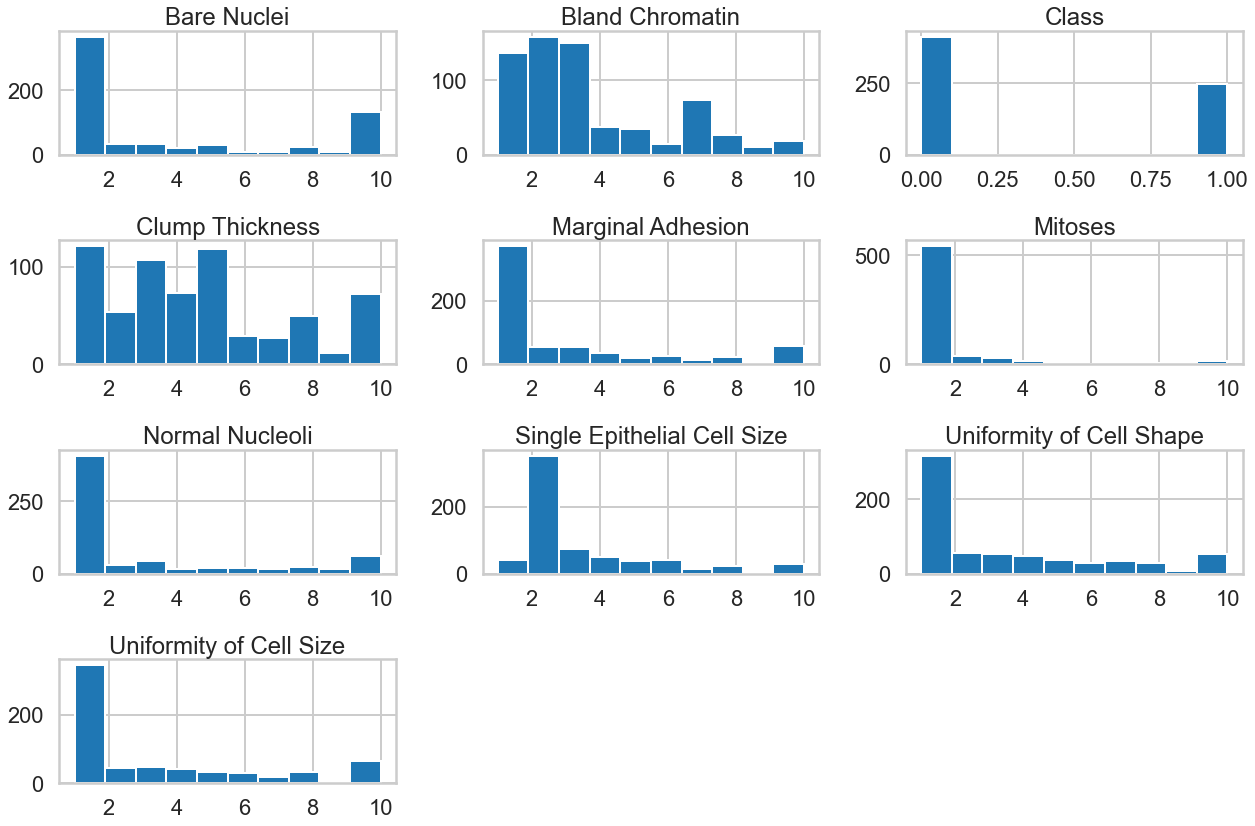

In [19]:
# Visualize using histogram
bc.hist()
plt.tight_layout()

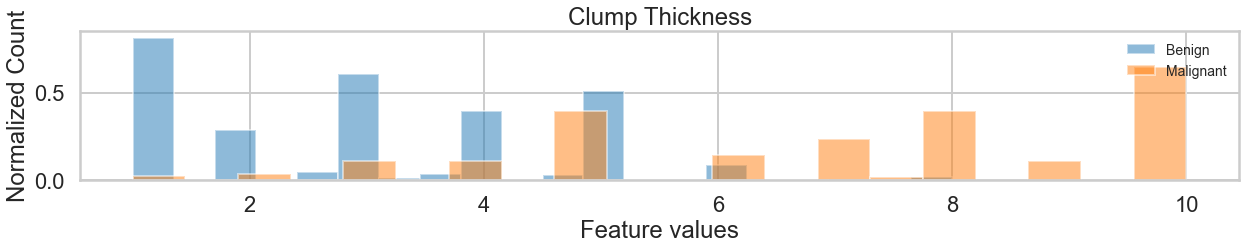

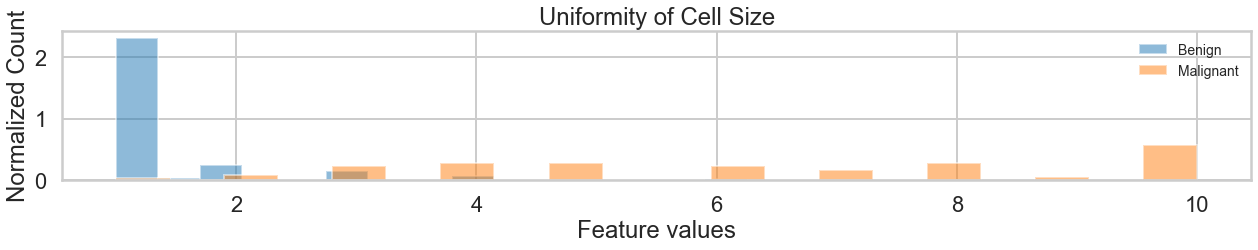

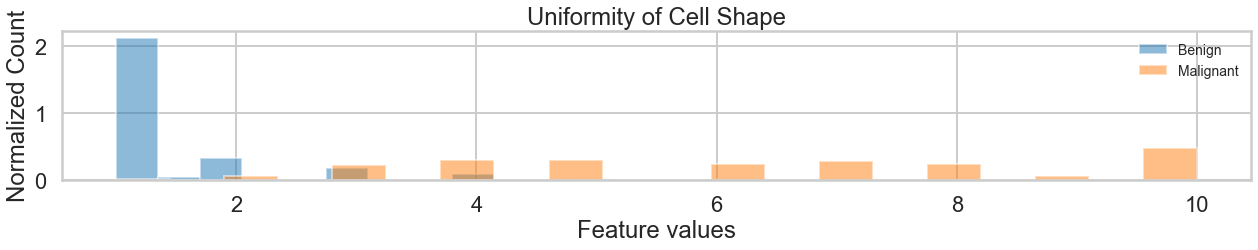

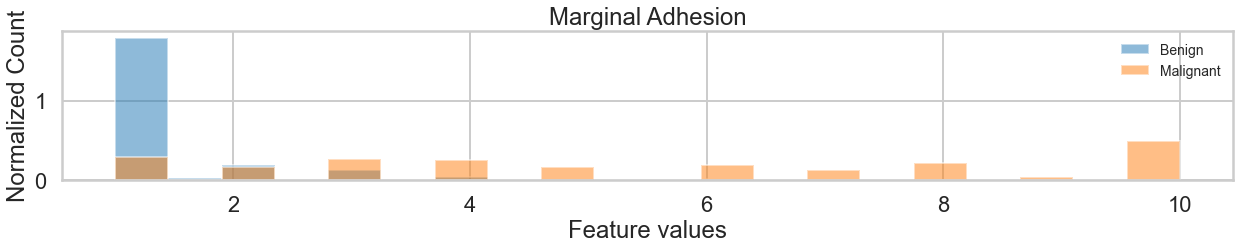

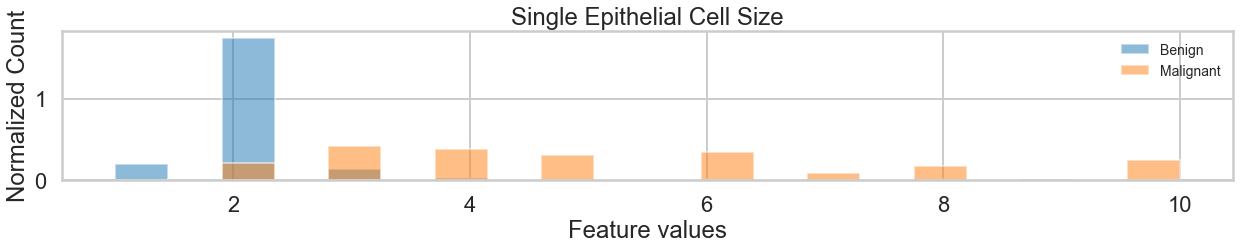

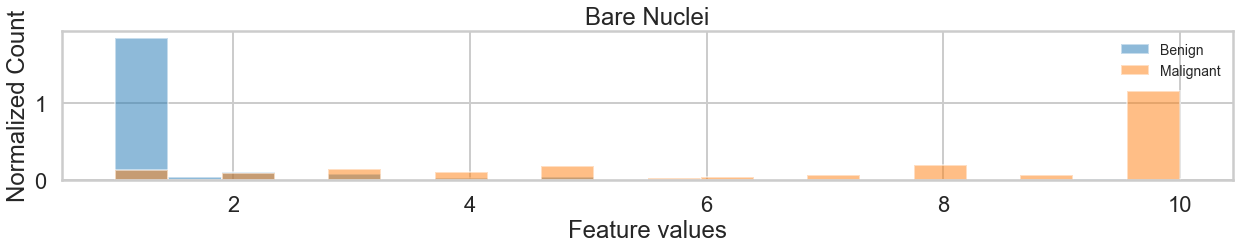

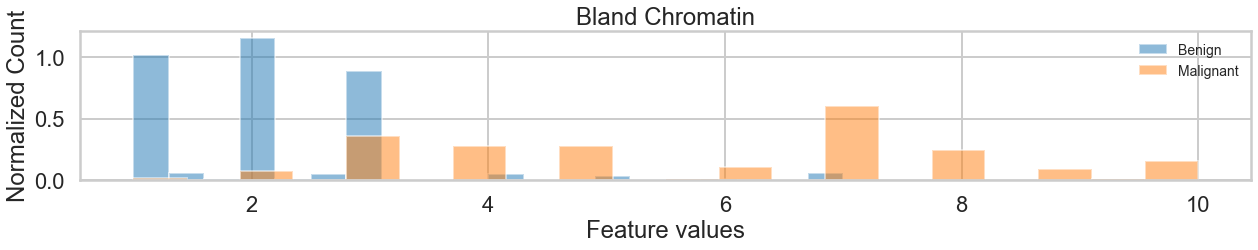

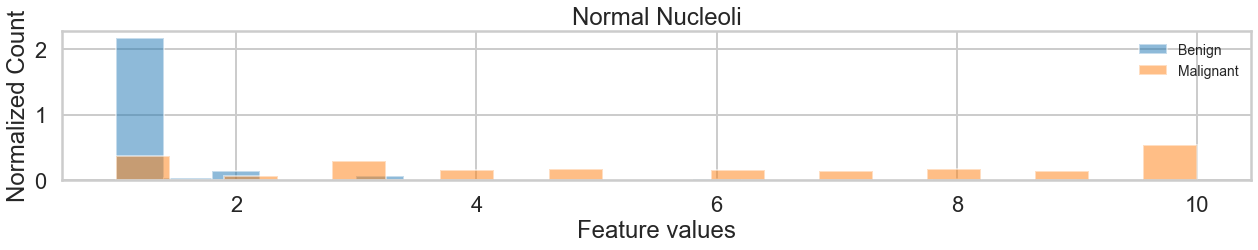

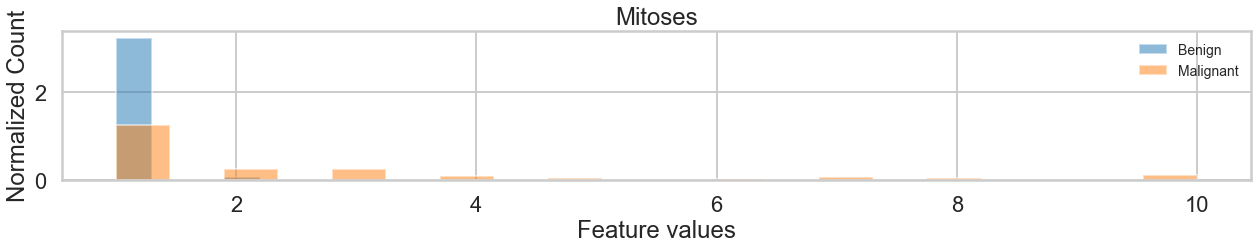

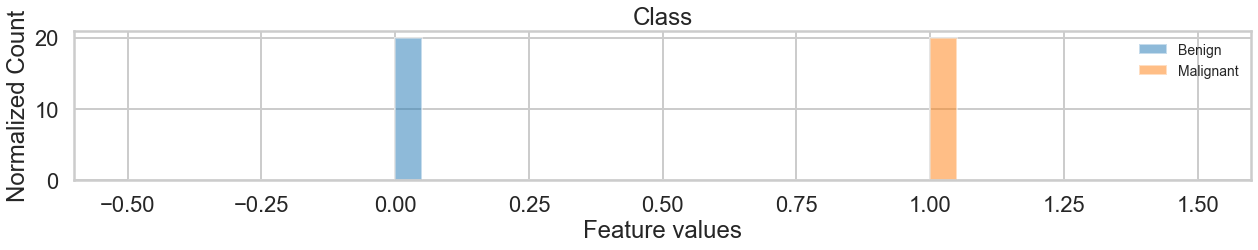

<Figure size 1296x864 with 0 Axes>

In [20]:
# Distribution of feature values for Benign vs. Malignant cancers
benign = bc[bc['Class'] == 0]
malignant = bc[bc['Class'] == 1]

for col in bc.columns:
    plot_hist([benign, malignant], 
              col, 
              labels=['Benign', 'Malignant'], 
              normalized = True)
plt.tight_layout()

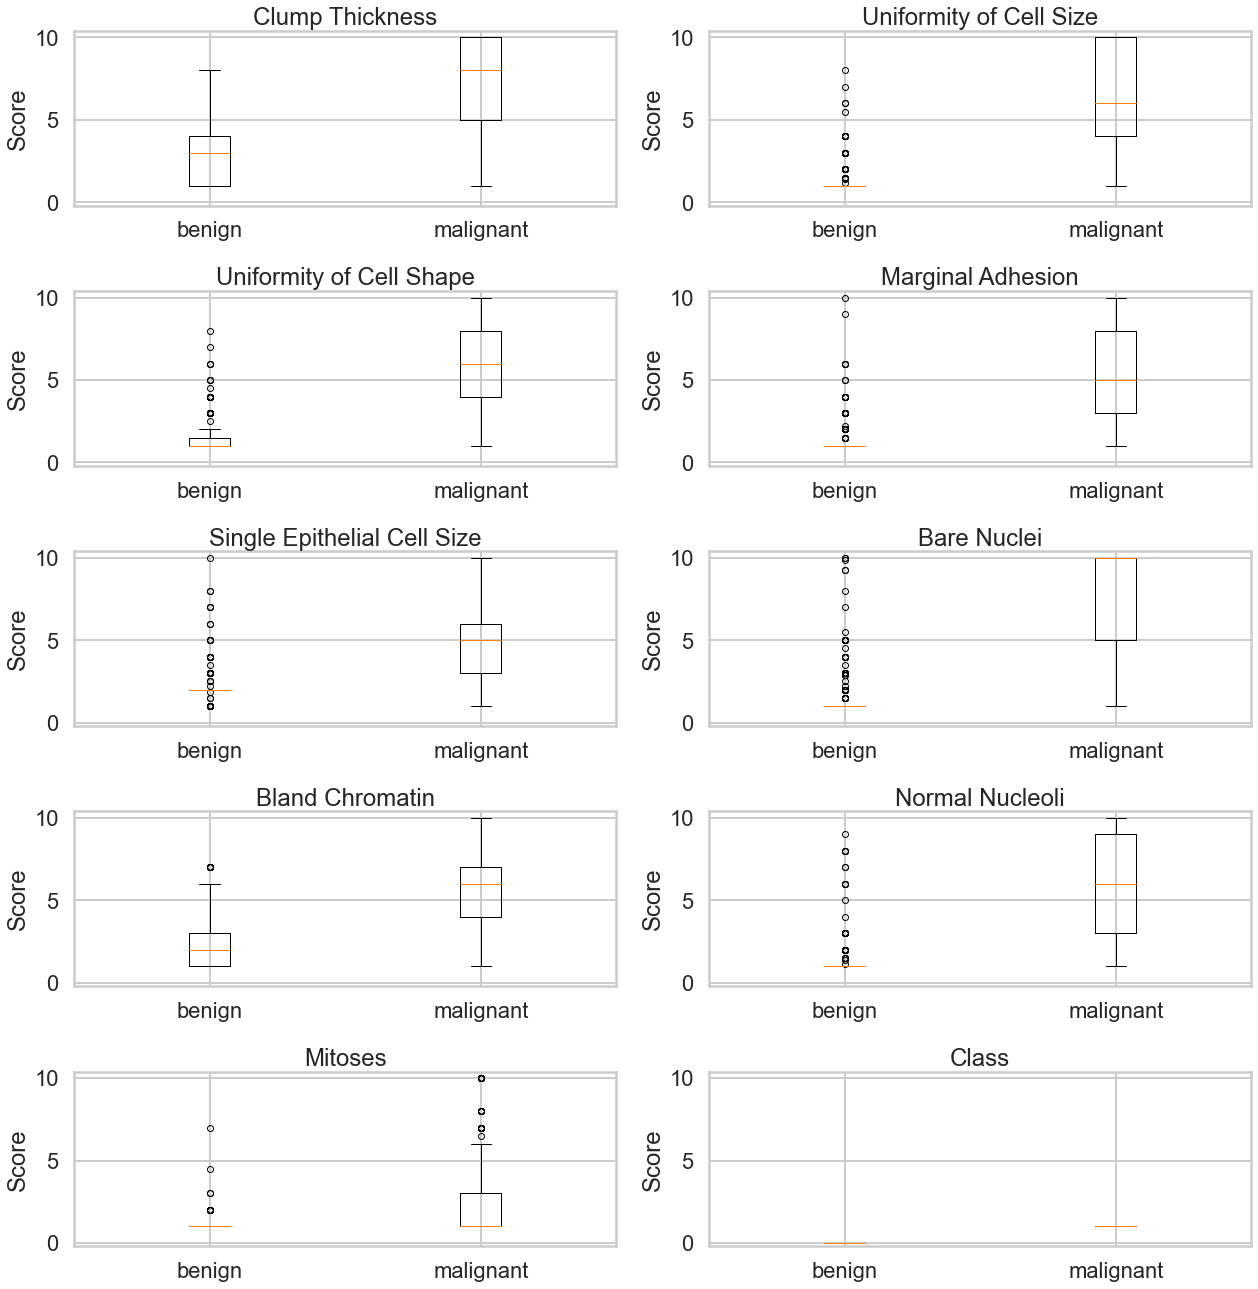

In [21]:
# Visualize using boxplot
i = 1
plt.figure(figsize=(18,36))
for col in bc.columns:
    plt.subplot(10, 2, i)
    axes = plt.boxplot([benign[col], malignant[col]], 
            labels = ['benign', 'malignant'],
           positions = [1, 2]);
    plt.title(col)
    plt.ylabel('Score')
    plt.ylim(-0.2, 10.4)
    i += 1
plt.tight_layout()

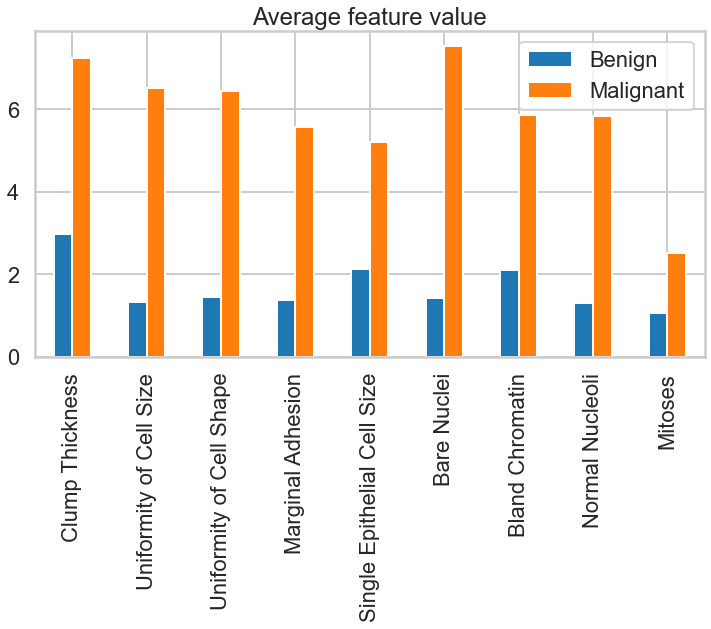

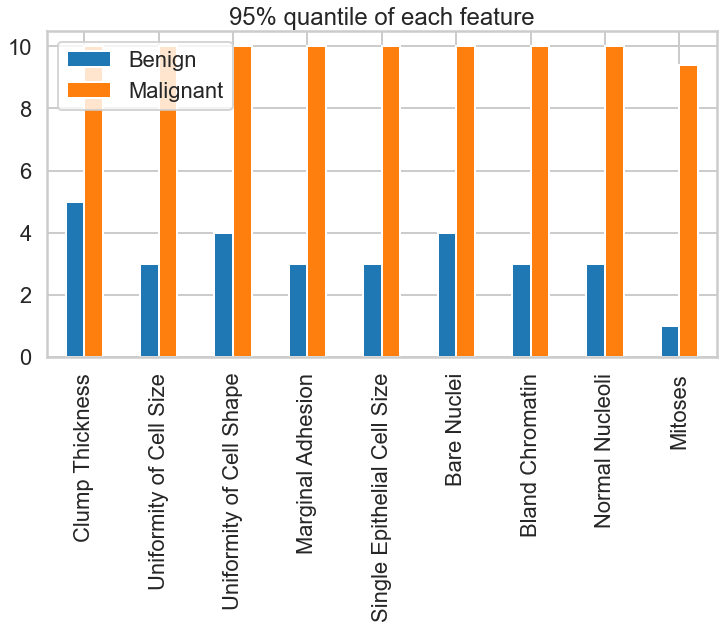

In [22]:
# Plot mean of each feature by Class
bc.groupby('Class').mean().transpose().plot(kind = 'bar', figsize = (12,6), title = 'Average feature value').legend(["Benign", "Malignant"])

# Plot 95% quantile of each feature by Class
bc.groupby('Class').quantile(.95).transpose().plot(kind = 'bar', figsize = (12,6), title = '95% quantile of each feature').legend(["Benign", "Malignant"])

<b>Normality test.</b> None of the features have a normal distribution.

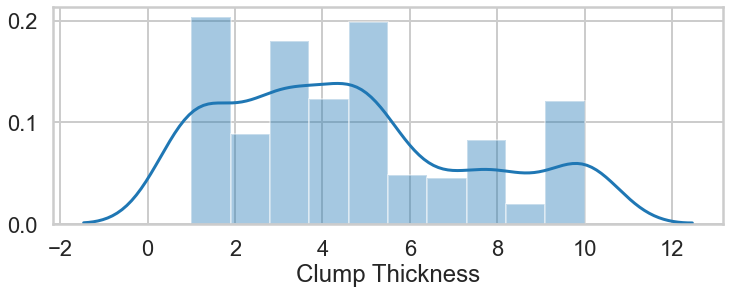

0.5457186046533653 -0.7285606048124023


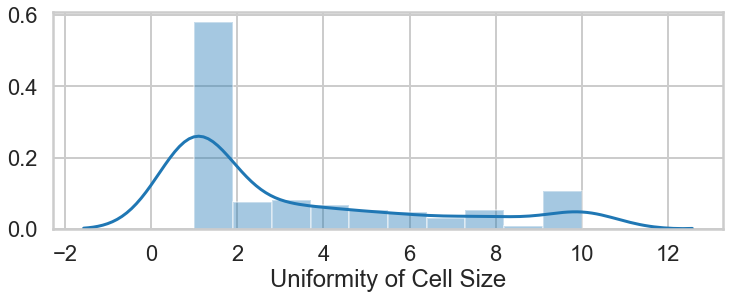

1.126796289529159 -0.1502344309875121


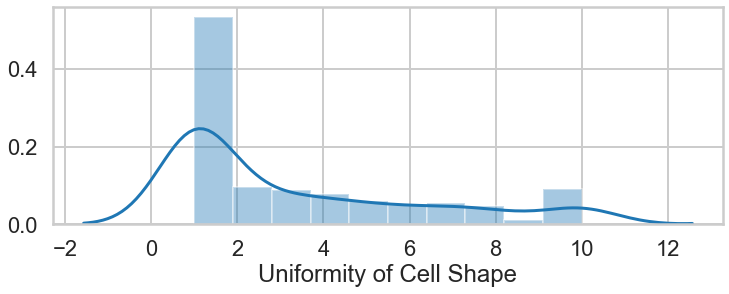

1.0703185064403093 -0.18009880594970618


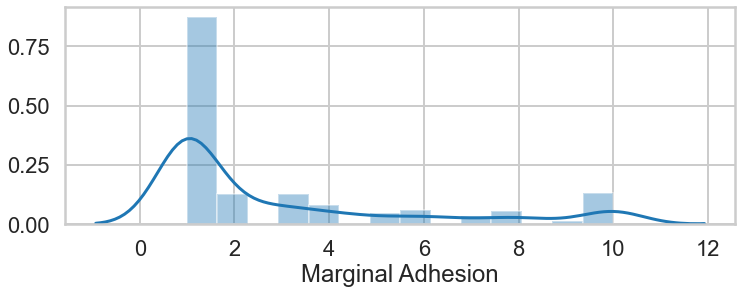

1.4073780070491826 0.6084896066824901


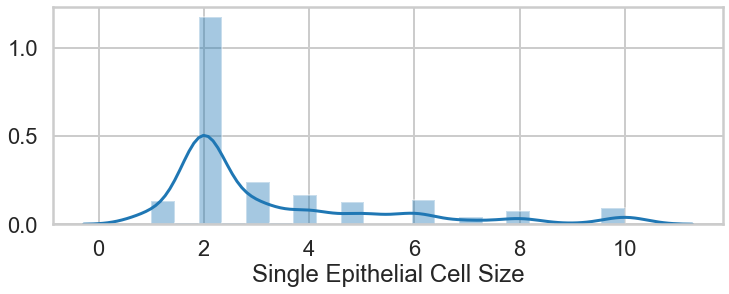

1.6320136895806947 1.8847971562278385


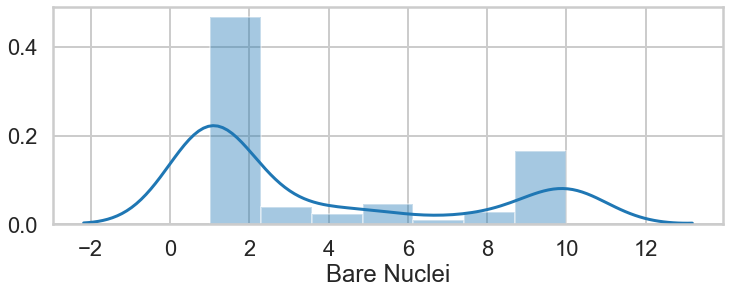

0.8953927399390346 -0.9570634465163166


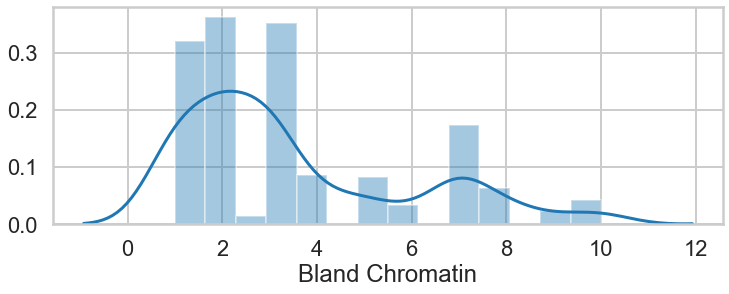

1.0250756837976625 -0.009405528712372213


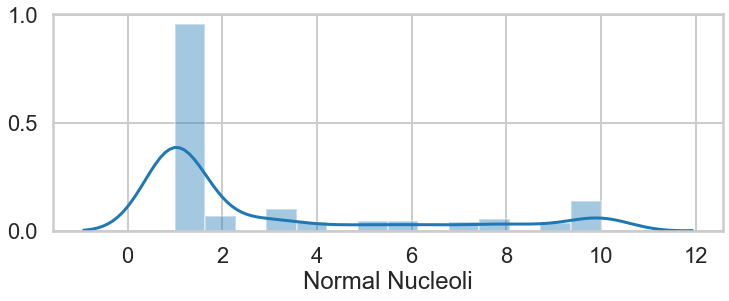

1.3095941715618917 0.1511983985390346


{'Clump Thickness': 0.9076112508773804,
 'Uniformity of Cell Size': 0.7393113374710083,
 'Uniformity of Cell Shape': 0.7704156637191772,
 'Marginal Adhesion': 0.6938114166259766,
 'Single Epithelial Cell Size': 0.7355117797851562,
 'Bare Nuclei': 0.695419192314148,
 'Bland Chromatin': 0.8477568626403809,
 'Normal Nucleoli': 0.6684378385543823}

In [23]:
normality_test(bc, bc.columns[:-2])

## Feature correlation

<b>Feature correlation with response variable (Class).</b> The features with the highest correlation with malignancy (Class) include: Uniformity of Cell Size, Uniformity of Cell Shape, Bare Nuclei, Bland Chromatin, and Clump Thickness.

In [24]:
bc.corr()['Class'][:-1].sort_values(ascending = False)

Uniformity of Cell Size        0.815
Uniformity of Cell Shape       0.813
Bare Nuclei                    0.806
Bland Chromatin                0.747
Clump Thickness                0.726
Normal Nucleoli                0.704
Marginal Adhesion              0.696
Single Epithelial Cell Size    0.670
Mitoses                        0.417
Name: Class, dtype: float64

Text(0.5, 1.0, 'Correlation of features with Class')

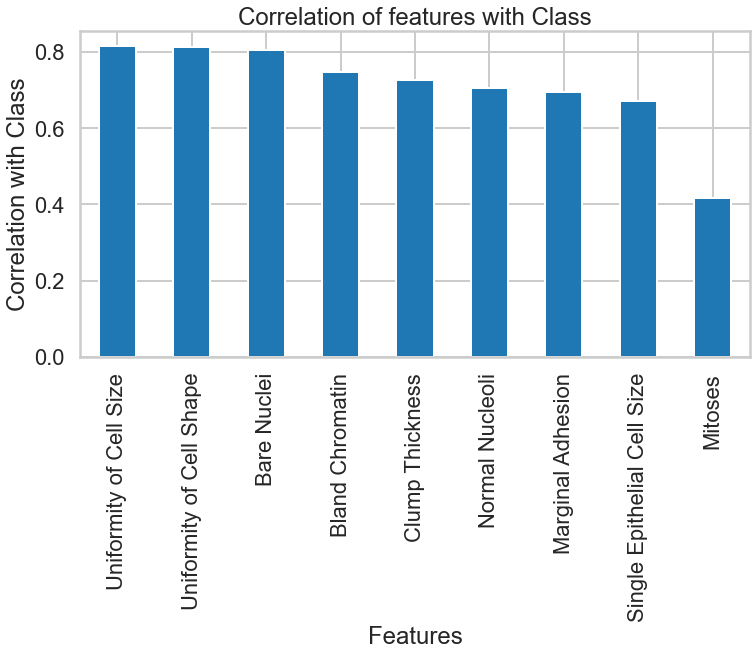

In [25]:
# Correlation of features with outcome (Class)
plt.figure(figsize = (12, 6))
ax = bc.corr()['Class'][:-1].sort_values(ascending = False).plot(kind='bar')
ax.set_xlabel('Features')
ax.set_ylabel('Correlation with Class')
ax.set_title('Correlation of features with Class')

## Check multicollinearity

<b>Correlation matrix.</b> Two features, Uniformity of Cell Size and Uniformity of Cell Shape, are highly correlated. 

Text(0.5, 0.98, 'Correlation Matrix')

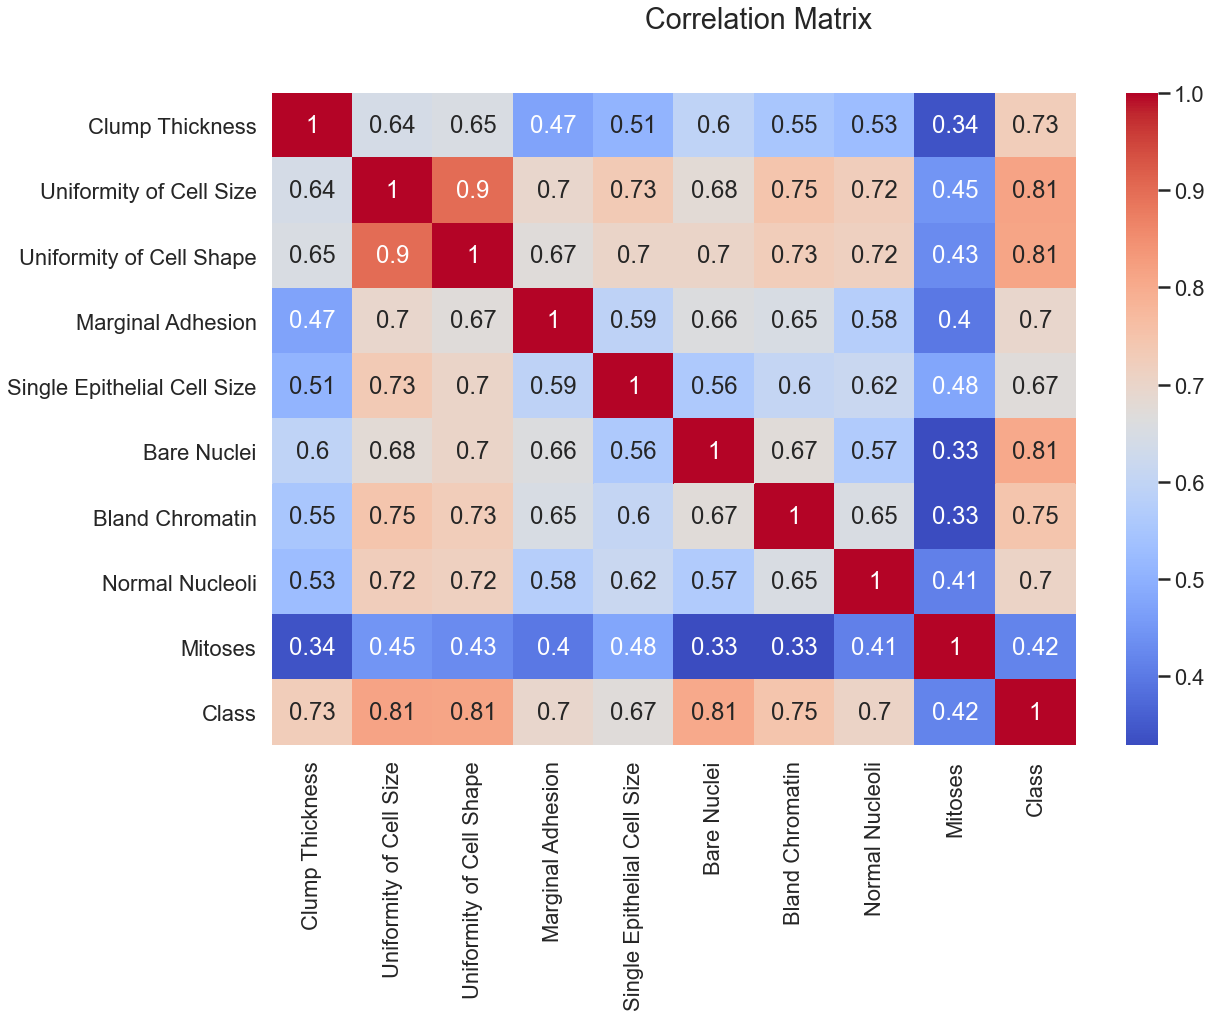

In [26]:
# Correlation matrix to identify collinearity
sns.heatmap(bc.corr(),annot=True, cmap='coolwarm')
plt.suptitle('Correlation Matrix')

<b>Remove features with high collinearity.</b>

In [27]:
bc.drop(labels = 'Uniformity of Cell Size', axis = 1)

,Clump Thickness,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses,Class
ID,,,,,,,,,
3782750,10.0,7.0,3.0,4.0,2.0,7.0,7.0,1.0,1.0
6012650,10.0,4.0,6.0,2.0,10.0,2.0,3.0,1.0,1.0
6721130,7.0,6.0,10.0,4.0,10.0,5.0,3.0,1.0,1.0
6916280,8.0,4.0,10.0,10.0,1.0,3.0,5.0,1.0,1.0
8325670,4.0,3.0,5.0,3.0,8.0,7.0,6.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...
1369821,10.0,10.0,10.0,5.0,10.0,10.0,10.0,7.0,1.0
1371026,5.0,10.0,10.0,4.0,10.0,5.0,6.0,3.0,1.0
1371920,5.0,1.0,1.0,2.0,1.0,3.0,2.0,1.0,0.0


# Classification
For this analysis, it is critical to identify patients with malignant breast cancer. Therefore recall, which minimizes false negative rate, is the most important metric in determining model performance since misidentifying a malignant tumor as benign (i.e., False Negative) is much worse than misidentifying a benign tumor as malignant (i.e., False Positive).

## Rescale features
In this case, all features have the same range (1-10), so rescaling is unnecessary.

In [28]:
# scaled_data = scaleData(bc.loc[:, "Clump Thickness" : "Mitoses"], method = 'std')

## Class balance

This dataset contains a slight imbalance (2:1) of benign:malignant cancers. SMOTE can be used in this case to oversample the minority class.

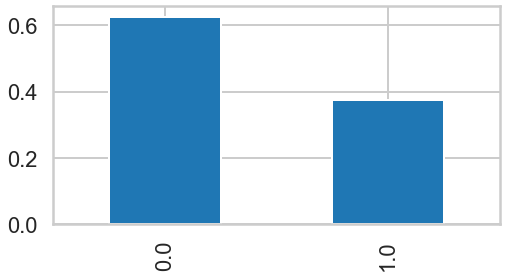

In [29]:
plt.figure(figsize = (8,4))
(bc['Class'].value_counts()/len(bc)).plot(kind='bar')

### Downsample majority class using resample

In [30]:
df_majority = benign
df_minority = malignant
print("Number of samples in majority class: {}".format(len(df_majority)))
print("Number of samples in minority class: {}".format(len(df_minority)))

# Downsample majority class
from sklearn.utils import resample
df_majority_downsampled = resample(df_majority,
                                 replace=False,    # sample without replacement
                                 n_samples=len(df_minority),     # to match minority class
                                 random_state=123) # reproducible results
print("Number of samples in majority class after downsampling: " + str(len(df_majority_downsampled)))

# Combine minority class with downsampled majority class
df_downsampled = pd.concat([df_majority_downsampled, df_minority])
print("Number of samples in dataset after downsampling: " + str(len(df_downsampled)))

# Display new class counts
df_downsampled.groupby(['Class']).size()
df_downsampled = df_downsampled.sample(n=len(df_downsampled), random_state=42)
df_downsampled_y = pd.DataFrame(df_downsampled['Class'])
df_downsampled = pd.DataFrame(df_downsampled.loc[:, "Clump Thickness" : "Mitoses"])

Number of samples in majority class: 414
Number of samples in minority class: 247
Number of samples in majority class after downsampling: 247
Number of samples in dataset after downsampling: 494


### Upsample minority class using SMOTE

## Train test split

The dataset was split into 70/30 to train and test the classification model.

In [31]:
# Original dataset with imbalanced class (no downsampling or upsampling performed)
X = bc[bc.columns[:-1]]
y = bc['Class']

# Downsampled dataset
# X = df_downsampled
# y = df_downsampled_y
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

# Upsampled dataset


# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

## Logistic Regression

### Sklearn

<b>Train model.</b>

In [32]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
predictions = logreg.predict(X_test)

<b>Model performance.</b> Overall performance of the logistic regression is very good, with a recall of 0.98 and F1-score of 0.98. 

If more time was available, I would bootstrap the data in order to better understand the average performance of the model.

In [33]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

         0.0       0.98      0.99      0.99       125
         1.0       0.99      0.97      0.98        74

    accuracy                           0.98       199
   macro avg       0.99      0.98      0.98       199
weighted avg       0.98      0.98      0.98       199



<b>ROC curve.</b>

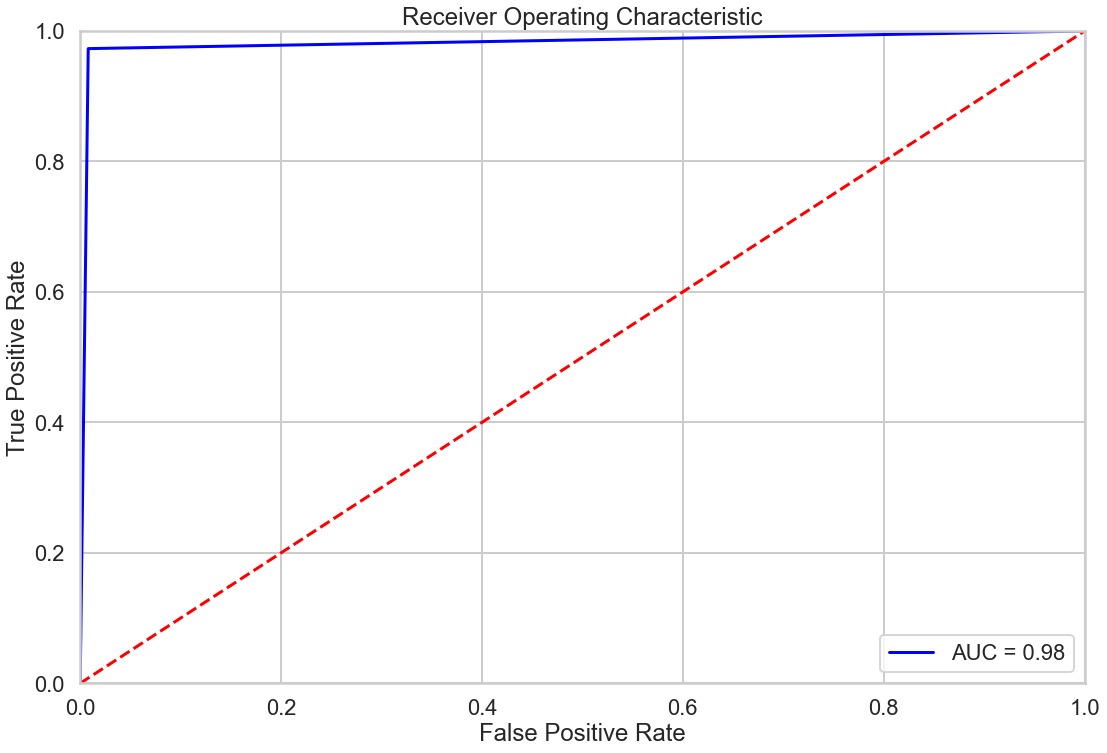

In [34]:
fpr, tpr, threshold = metrics.roc_curve(y_test, predictions)
roc_auc = metrics.auc(fpr, tpr)

# plt.style.use('classic')
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

<b>Feature importance.</b>

In [35]:
# Calculate coefficient significance of each feature
p_value = logit_pvalue(logreg, X)
significance = p_value < 0.05

coefficients = pd.concat([pd.DataFrame(bc.columns[:-1], columns = ['Feature']),
                          pd.DataFrame(np.transpose(logreg.coef_), columns = ['Coefficient']),
                          pd.DataFrame(np.transpose(p_value[1:]), columns = ['p-value']), 
                          pd.DataFrame(np.transpose(significance[1:]), columns = ['significance'])], 
                         axis = 1)
coefficients

,Feature,Coefficient,p-value,significance
0,Clump Thickness,0.532,3.835e-05,True
1,Uniformity of Cell Size,0.085,6.423e-01,False
2,Uniformity of Cell Shape,0.234,2.589e-01,False
3,Marginal Adhesion,0.309,3.539e-03,True
4,Single Epithelial Cell Size,0.142,3.254e-01,False
5,Bare Nuclei,0.349,2.127e-05,True
6,Bland Chromatin,0.386,1.156e-02,True
7,Normal Nucleoli,0.069,4.860e-01,False
8,Mitoses,0.714,2.175e-02,True


### Statsmodels

Overall performance of the logistic regression is unexpectedly high, with a recall of 0.93 and F1-score of 0.93. This may be due to the presence of multicollinearity.

If more time was available, I would bootstrap the data in order to better understand the average performance of the model.

<b>Logistic Regression using statsmodels.</b>

In [36]:
sm_model = sm.Logit(y, sm.add_constant(X)).fit(disp=0)
print(sm_model.pvalues)
sm_model.summary()

const                          3.457e-18
Clump Thickness                6.997e-05
Uniformity of Cell Size        6.709e-01
Uniformity of Cell Shape       1.724e-01
Marginal Adhesion              3.613e-03
Single Epithelial Cell Size    7.116e-01
Bare Nuclei                    2.086e-05
Bland Chromatin                2.011e-02
Normal Nucleoli                1.945e-01
Mitoses                        2.891e-02
dtype: float64


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  Class   No. Observations:                  661
Model:                          Logit   Df Residuals:                      651
Method:                           MLE   Df Model:                            9
Date:                Fri, 18 Sep 2020   Pseudo R-squ.:                  0.8748
Time:                        11:25:10   Log-Likelihood:                -54.709
converged:                       True   LL-Null:                       -436.84
Covariance Type:            nonrobust   LLR p-value:                1.040e-158
===============================================================================================
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const                         -10.1420      1.166     -8.695      0.000     -12.428      -7.856
Clump Thickness                 0.5647      0.142      3.976      0.000       0.286       0.843
Uniformity of Cell Size         0.0853      0.201      0.425      0.671      -0.308       0.479
Uniformity of Cell Shape        0.3138      0.230      1.364      0.172      -0.137       0.765
Marginal Adhesion               0.3285      0.113      2.910      0.004       0.107       0.550
Single Epithelial Cell Size     0.0560      0.151      0.370      0.712      -0.241       0.353
Bare Nuclei                     0.3744      0.088      4.255      0.000       0.202       0.547
Bland Chromatin                 0.3867      0.166      2.324      0.020       0.061       0.713
Normal Nucleoli                 0.1377      0.106      1.297      0.195      -0.070       0.346
Mitoses                         0.7339      0.336      2.185      0.029       0.076       1.392
===============================================================================================
"""

## Decision Tree
The base model already has good performance, with recall of 0.97 and f1-score of 0.97.

Note: Need to perform hyperparameter tuning.

In [37]:
dt_model = DecisionTreeClassifier()
dt_model.fit(X_train, y_train) # Fit Model using training data
predictions = dt_model.predict(X_test) # Predict using test data
print(classification_report(predictions, y_test))

              precision    recall  f1-score   support

         0.0       0.98      0.98      0.98       124
         1.0       0.97      0.96      0.97        75

    accuracy                           0.97       199
   macro avg       0.97      0.97      0.97       199
weighted avg       0.97      0.97      0.97       199



## Random Forest
The base model already has good performance, with recall of 0.98 and f1-score of 0.98.

Note: Need to perform hyperparameter tuning.

In [38]:
rf_model = RandomForestClassifier(n_estimators=200)
rf_model.fit(X_train, y_train) # Fit Model using training data
predictions = rf_model.predict(X_test) # Predict using test data
print(classification_report(predictions, y_test))

              precision    recall  f1-score   support

         0.0       0.98      0.99      0.98       123
         1.0       0.99      0.96      0.97        76

    accuracy                           0.98       199
   macro avg       0.98      0.98      0.98       199
weighted avg       0.98      0.98      0.98       199



## XGBoost
The base model already has good performance, with recall of 0.98 and f1-score of 0.98.

Note: Need to perform hyperparameter tuning.

In [42]:
xgb_model = GradientBoostingClassifier()
xgb_model.fit(X_train, y_train) # Fit Model using training data
predictions = xgb_model.predict(X_test) # Predict using test data
print(classification_report(predictions, y_test))

              precision    recall  f1-score   support

         0.0       0.98      0.99      0.98       123
         1.0       0.99      0.96      0.97        76

    accuracy                           0.98       199
   macro avg       0.98      0.98      0.98       199
weighted avg       0.98      0.98      0.98       199



## Principal Components Analysis

[pca] >Processing dataframe..
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [9] columns of the input data.
[pca] >Fitting using PCA..
[pca] >Computing loadings and PCs..
[pca] >Computing explained variance..
[pca] >Number of components is [7] that covers the [95.00%] explained variance.
[pca] >Outlier detection using Hotelling T2 test with alpha=[0.05] and n_components=[5]
[pca] >Outlier detection using SPE/DmodX with n_std=[2]


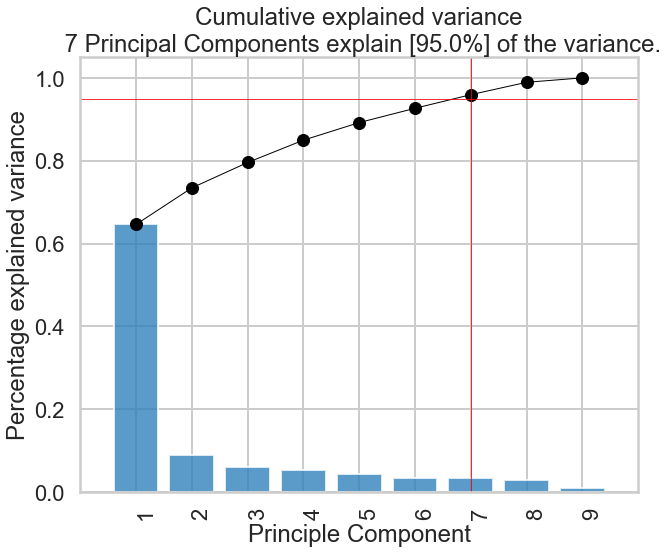

<Figure size 1296x864 with 0 Axes>

In [39]:
feats = ['Clump Thickness','Uniformity of Cell Size',
              'Uniformity of Cell Shape', 'Marginal Adhesion',
              'Single Epithelial Cell Size', 'Bare Nuclei',
              'Bland Chromatin', 'Normal Nucleoli', 'Mitoses']
feats_sc=StandardScaler().fit_transform(bc[feats])
pca_ = pca(n_components=0.95)#Want to explain 95% of the variance
pc = pca_.fit_transform(pd.DataFrame(feats_sc,columns=feats ))
fig, ax = pca_.plot()

# Concluding remarks
(1) What features of a cell are the largest drivers of malignancy?

* The features with the highest correlation with malignancy (Class) are: Bare Nuclei, Uniformity of Cell Size, Uniformity of Cell Shape, Bland Chromatin, and Clump Thickness. However, it is noted that there is collinearity between the Uniformity of Cell Size and Uniformity of Cell Shape. See reponse to objective #3 for more details on how to address this issue.

(2) How would a physician use your product?

* Typically a trained pathologist, rather than the physician of the patient, is the person responsible for scoring the cell features. The pathologist most likely enters the cell feature scores into a database. The app would then flag patients or cases with a high likelihood of having a malignant tumor and send a push notification to the physician of the patient for further review. This saves time for both the pathologist and physician and allows them to focus on their other priorities by reducing the amount of time spent reviewing the feature information, classifying maglinancy, and coordinating to explain and exchange details regarding the patient.

(3) There is a non-zero cost in time and money to collect each feature about a given cell. How would you go about determining the most cost-effective method of detecting malignancy?

* Feature selection or PCA in order to address multicollinearity of the features and reduce the number of features required for classification without sacrificing performance.

* An additional feature that would be useful in determining the most cost-effective methods of detecting malignancy would be a measure of the time or cost of a physician to acquire these features. For example, the amount of time spent to determine each feature as well as the salary of a pathologist or physician (Hourly-based? Case-based? Annual salary independent of time spent working?).